# Control experiment. Regression by Random forest regressors (RFRs)
- in this notebook, we will simply train RFRs with a Wikipedia database
- this is just a conventional way to predict properties via materials informatics
    - for each parameter, RFR models will be prepared
    - paremeters will be simply predicted from "60-dimensional descriptors" of the corresponding compound
        - these are used as the enbeddings to express chemicals in graph nodes

In [3]:
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import copy

sys.path.append("../MIGraph/Encoders/")


# prepare database
1. load chemical properties database
- calclate descriptors

In [4]:
#load wikipedia database
path="praparingGraphs/input/additional_simple_comps/20190520wikipedia.csv"
df=pd.read_csv(path)
df=df.set_index("SMILES")

#drop unnecesary columns
df=df.drop(["ID","CompName","CASNo"],axis=1)

targetParams=list(df.columns)
print("params to be learned: ", targetParams)
df

params to be learned:  ['pKa', 'Viscosity', 'Vapor pressure', 'Thermal Conductivity', 'Refractive index', 'Melting temperature', 'Absolute molar magnetic susceptibility', 'Partition coefficient', 'Molar Heat Capacity', 'Heat Capacity', 'Dipole Moment', 'Density', 'Absolute standard enthalpy of formation', 'Boiling temperature', 'Band gap']


,pKa,Viscosity,Vapor pressure,Thermal Conductivity,Refractive index,Melting temperature,Absolute molar magnetic susceptibility,Partition coefficient,Molar Heat Capacity,Heat Capacity,Dipole Moment,Density,Absolute standard enthalpy of formation,Boiling temperature,Band gap
SMILES,,,,,,,,,,,,,,,
[Cd]=[Te],NaN,NaN,NaN,6.2,2.67,1041,NaN,NaN,NaN,210.0,NaN,NaN,NaN,1050,1.5
N#[Ta],NaN,NaN,NaN,NaN,NaN,3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B#[Re]#B,NaN,NaN,NaN,NaN,NaN,2400,NaN,NaN,NaN,NaN,NaN,12.7,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,900/1100,NaN,NaN,NaN,NaN,NaN,11.3,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,2797,NaN,NaN,NaN,NaN,NaN,11.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,70/73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#prepdata.CompDat class can calculate 60-dim vectors for smiles (which are normally enbedded in graph nodes in step2)

from PrepDataset import PrepDataset
allCompundsPath="praparingGraphs/output/allcompounds.csv.gz"
prepdata=PrepDataset()
prepdata.setCompoundEncoder(allCompundsPath)



/home/kh/anaconda3/envs/chem/lib/python3.6/site-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy) version 6.0.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy>=7.2.0,<8.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))
 32%|███▏      | 424/1308 [00:00<00:00, 4238.70it/s]

number of smiles:  1308
calculate fingerprints
error  nan
error  [H]1[BH]2[H][BH]3[BH]24[BH]1[H][BH]4[H]3
error  [K+].o=c(-c(=o)o1)o[Fe-3]123(oc(-c(=o)o2)=o)oc(-c(=o)o3)=o.[K+].[K+]
error  [OH2][Re](=O)(=O)(=O)([OH2])O[Re](=O)(=O)=O
error  B1([H]3)(C2CCCC1CCC2)[H]B34C2CCCC4CCC2
error  [Cl-].[Cl-].[Zn2+]
error  [Na+].[Na+].[Na+].[PH6-3]
error  FCl(F)(F)(F)F
error  c1=cc=c[cH+]c=c1
error  [Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]
error  [Na+].o=c(-c(=o)o1)o[Fe-3]123(oc(-c(=o)o2)=o)oc(-c(=o)o3)=o.[Na+].[Na+]
error  c1[nH]c2c(n1)c(=O)nc(n2)N
error  [Cl-].[Cl-].[Ni2+]
error  F[Si-2](F)(F)(F)(F)F.[NH4+].[NH4+]
error  o=c([o-])C.[N+H4]


100%|██████████| 1308/1308 [00:00<00:00, 4293.94it/s]


error  FBr(F)(F)(F)F
error  O=[Cl]=O
error  FCl(=O)(=O)=O
error  [Cl-].[Cl-].[Cu2+]
error  [O-2]=[Ce+4]=[O-2]
error  [Cl-].[Cl-].[Cl-].[In3+]
loading files
compressing and scaling


In [6]:
#merge descriptor info
descDf=pd.DataFrame.from_dict(prepdata.CompDat.IDtoDescs).T
descColumns=["D"+str(i) for i in range(descDf.shape[1])]
descDf.columns=descColumns

mergeDf=df.merge(descDf, left_index=True, right_index=True, how='left')

#delete inappropriate smiles
mergeDf=mergeDf.dropna(subset=['D0'])


# machine learning
1. select target property to be predicted (e.g, density)
- delete missing data rows
- split database into train and test datasets (9:1)
- machine learning by rfr

## the results can be compared with data shown in Table 1 in Suppl. info of the article

In [7]:
logList=[
    "Absolute molar magnetic susceptibility",
    "Absolute standard enthalpy of formation",
    "Thermal Conductivity",
    "Vapor pressure",
    "Viscosity"    
]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

SPL_RATIO=0.9

def plot(x,y,tx,ty):
    global target
    global sc
    """
    y=sc.inverse_transform(y)
    x=sc.inverse_transform(x)
    ty=sc.inverse_transform(ty)
    tx=sc.inverse_transform(tx)
    """

    plt.figure(figsize=(5,5))
    plt.axes().set_aspect('equal', 'datalim')
    plt.plot(x,y,"o")
    plt.plot(tx,ty,"o")

    plt.title(target)
    print("trR2: ",r2_score(x,y))
    print("trMAE: ",mean_absolute_error(x,y))
    print("teR2: ",r2_score(tx,ty))
    print("teMAE: ",mean_absolute_error(tx,ty))

def ML(target):
    global sc
    datasetColumns=copy.deepcopy(descColumns)
    datasetColumns.append(target)

    datasetDf=copy.deepcopy(mergeDf)[datasetColumns]
    datasetDf=datasetDf.dropna(subset=[target])

    tList=datasetDf[target].values
    tList=[str(i).split("/")[0] for i in tList]
    tList=[i if i is not "0" else 0 for i in tList]
    datasetDf[target]=tList
    datasetDf[target]=datasetDf[target].astype(float)

    def mySum(x):
        return np.log(x+1/10000)
    
    if target in logList:
        print("to log")
        datasetDf[target]=datasetDf[target].apply(mySum)

    datasetDf=datasetDf.dropna(subset=[target])

    sc=StandardScaler()
    datasetDf[target]=sc.fit_transform(datasetDf[[target]])

    tr,te=train_test_split(datasetDf,train_size=SPL_RATIO)

    rfr=RandomForestRegressor(
        #you can optimize hyperparams, but the results will not improve significantly
        max_depth=5
    )
    rfr.fit(tr[descColumns],tr[target])

    predTrain=rfr.predict(tr[descColumns])
    predTest=rfr.predict(te[descColumns])

    print(target)
    print(predTrain.shape[0], " train samples")
    print(predTest.shape[0], " test samples")
    
    plot(tr[target],predTrain,te[target],predTest)
    print("\n")

to log
Absolute molar magnetic susceptibility
248  train samples
28  test samples
trR2:  0.6932321689192336
trMAE:  0.38713023050205037
teR2:  0.019998271660223055
teMAE:  0.46304170494111


to log
Absolute standard enthalpy of formation
77  train samples
9  test samples
trR2:  0.8089423715488435
trMAE:  0.2825748838973086
teR2:  -3.957942933866736
teMAE:  0.7049448596277839


Band gap
9  train samples
1  test samples
trR2:  0.8847704518283053
trMAE:  0.266487889579388
teR2:  nan
teMAE:  0.8128017123814345


Boiling temperature
604  train samples
68  test samples
trR2:  0.6337487964834542
trMAE:  0.3652888176744759
teR2:  0.03235191240891433
teMAE:  0.4875992611932446


Density
687  train samples
77  test samples
trR2:  0.6458031805427591
trMAE:  0.4074980800495754
teR2:  0.3657145588380898
teMAE:  0.4670139650597506


Dipole Moment
72  train samples
9  test samples
trR2:  0.8503143407320316
trMAE:  0.30065766893013457
teR2:  -0.19430255866165158
teMAE:  0.6572841912399521


Heat Capac

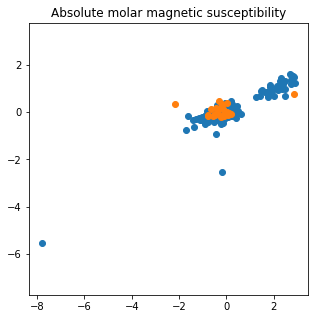

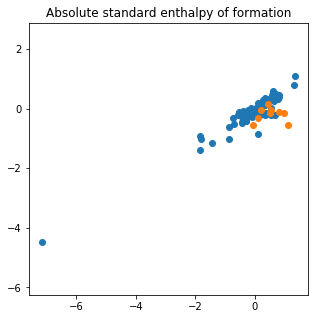

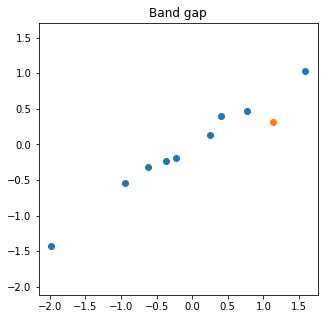

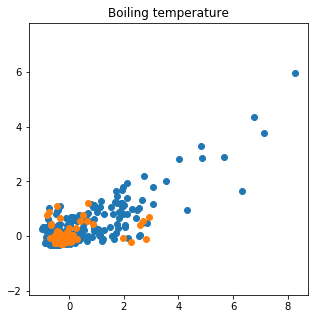

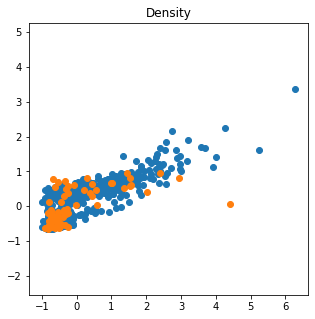

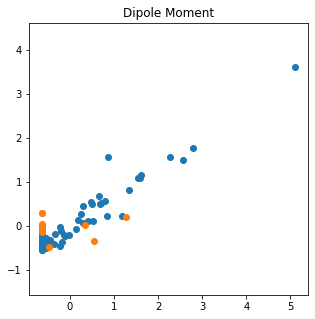

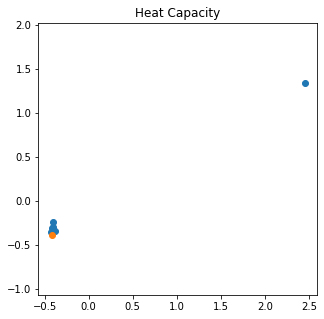

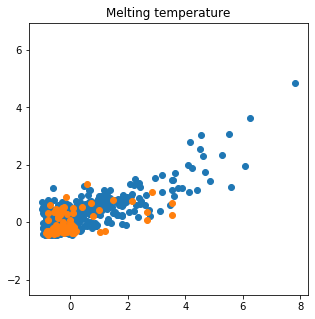

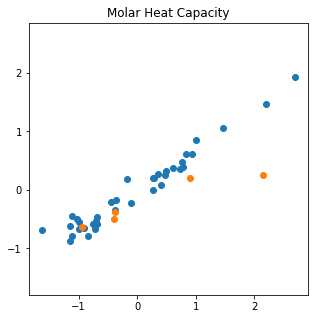

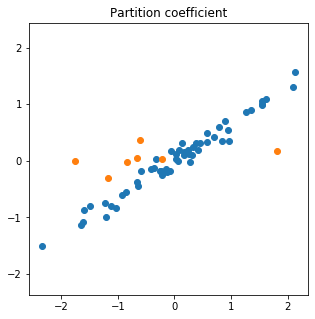

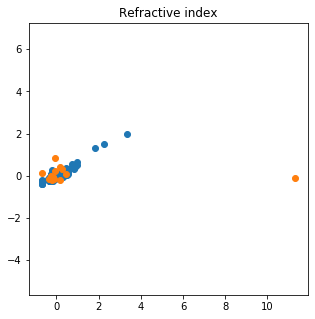

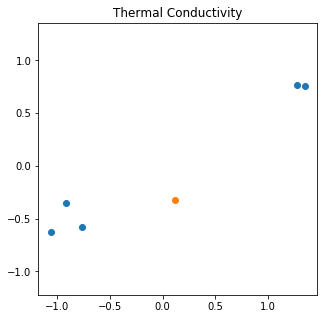

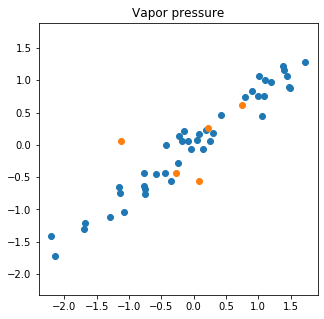

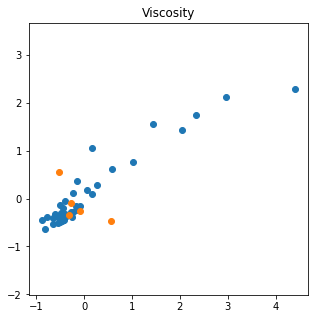

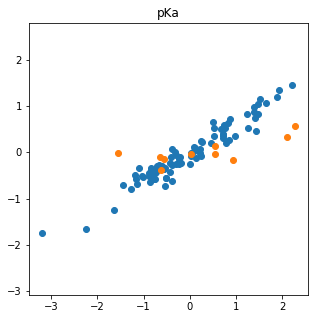

In [39]:
targetParams.sort()
for target in targetParams:
    ML(target)
    